# Testing software

In [61]:
import numpy as np
from matplotlib import pyplot as plt
import os
import stan_utility
import astropy.units as u
%load_ext autoreload
%autoreload 2
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sources

In [109]:
from python.source.simple_source import PointSource, DiffuseSource, TestSourceList
from python.source.flux_model import PowerLawSpectrum, IsotropicDiffuseBG
from python.source.parameter import Parameter
Parameter.clear_registry()
from python.source.atmospheric_flux import AtmosphericNuMuFlux
from python.backend.stan_generator import ParametersContext, TransformedParametersContext, ModelContext
from python.backend.variable_definitions import ParameterDef, ParameterVectorDef

In [110]:
# Define point source params
index = Parameter(2.2, "index", fixed=False, par_range=(1.1, 4))
luminosity = Parameter(6E46 * (u.erg / u.s), "luminosity", fixed=True, 
                       par_range=(0, 1E60))

# Define diffuse flux inputs
diffuse_norm = Parameter(1.44E-14 /u.GeV/u.m**2/u.s, "diffuse_norm", fixed=True, 
                         par_range=(0, np.inf))
diffuse_flux_model = IsotropicDiffuseBG(PowerLawSpectrum(diffuse_norm, 1E5*u.GeV, 
                                                         index, lower_energy=1E5*u.GeV, 
                                                         upper_energy=1E8*u.GeV))

In [111]:
# Define atmo_bg_flux
atmo_bg_flux = AtmosphericNuMuFlux(1E5 * u.GeV, 1E8 * u.GeV)
atmo_bg_flux.total_flux_int

<Quantity 1.80713726e-08 1 / (m2 s)>

In [112]:
# Loading from file
source_file = '../dev/statistical_model/data/test_SFR_pop.h5'
source_list = TestSourceList(source_file, luminosity, index, 1E5 * u.GeV, 1E8 * u.GeV)

# Select sources below zth = 1
zth = 1.0
source_list.select_below_redshift(zth)

# Add a diffuse background at z = 1
diffuse_bg = DiffuseSource('diffuse_bg', zth, flux_model=diffuse_flux_model)
source_list.add(diffuse_bg)

# Add an atmospheric background component
atmo_bg = DiffuseSource('atmo_bg', 0, flux_model=atmo_bg_flux)
source_list.add(atmo_bg)

In [113]:
# Associated fraction of our sources
source_ints = [source.flux_model.total_flux_int for source in source_list]
f = sum(source_ints[:-2]) / sum(source_ints)
print(f)

0.4212348324876962


## Precomputation

In [116]:
from python.precomputation import ExposureIntegral
from python.detector_model import NorthernTracksDetectorModel

In [117]:
time = 8 * u.year # years -> not used rn
Emin_det = 1.0e5 * u.GeV # GeV

exposure_integral = ExposureIntegral(source_list, NorthernTracksDetectorModel, 
                                     time, Emin_det)

exposure_integral()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11ca73a90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11d088450> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11ca7a190> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11d1f3d90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11ca7a110> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11d1bedd0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11d175250> already on stack
INFO:python.backend.code_gener

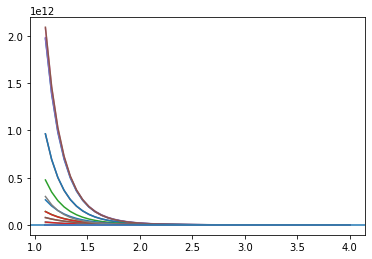

In [118]:
fig, ax = plt.subplots()
for _ in exposure_integral.integral_grid:
    ax.plot(exposure_integral.par_grids["index"], _)
ax.axhline(exposure_integral.integral_fixed_vals[0].value)

## Generate Stan code for simulation


In [131]:
from python.detector_model import NorthernTracksDetectorModel
from python.backend.stan_generator import (
    StanGenerator, GeneratedQuantitiesContext, DataContext, TransformedDataContext,
    FunctionsContext, Include, ForLoopContext, StanFileGenerator, WhileLoopContext, FunctionCall, ModelContext, IfBlockContext, ElseIfBlockContext, ElseBlockContext)
from python.backend.variable_definitions import ForwardVariableDef, ForwardArrayDef
from python.backend.expression import StringExpression
from python.backend.parameterizations import DistributionMode
import logging
logging.basicConfig(level=logging.WARN)

### Code to generate atmo events

In [132]:
with StanFileGenerator("stan_files/atmo_gen") as atmo_gen:
    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("interpolation.stan")
    
    # Increasing theta points too much makes compilation very slow
    # Could switch to passing array as data if problematic
    atmu_nu_flux = atmo_bg_flux.make_stan_function(theta_points=30)
    
    with DataContext():
        Edet_min = ForwardVariableDef("Edet_min", "real")
        Esrc_max = ForwardVariableDef("Esrc_max", "real")
        
        cosz_min = ForwardVariableDef("cosz_min", "real")
        cosz_max = ForwardVariableDef("cosz_max", "real")
    
    with TransformedDataContext():
        # If not used pop up in Stan file, blocking compilation...
        # Needs fixing
        StringExpression(["print(", Edet_min, ")"])
        StringExpression(["print(", Esrc_max, ")"])
        StringExpression(["print(", cosz_min, ")"])
        StringExpression(["print(", cosz_max, ")"])
    
    with ParametersContext():
        # Simulate from Edet_min and cosz bounds for efficiency 
        energy = ParameterDef("energy", "real", Edet_min, Esrc_max)
        coszen = ParameterDef("coszen", "real", cosz_min, cosz_max) 
        phi = ParameterDef("phi", "real", 0, 2*np.pi)
        
    with TransformedParametersContext():
        omega = ForwardVariableDef("omega", "vector[3]")
        zen = ForwardVariableDef("zen", "real")
        theta = ForwardVariableDef("theta", "real")     
        
        zen << FunctionCall([coszen], "acos")
        theta << FunctionCall([], "pi") - zen
        
        omega[1] << FunctionCall([theta], "sin") * FunctionCall([phi], "cos")
        omega[2] << FunctionCall([theta], "sin") * FunctionCall([phi], "sin")
        omega[3] << FunctionCall([theta], "cos")
        
    with ModelContext():
        
        logflux = FunctionCall([atmu_nu_flux(energy, omega)], "log")
        StringExpression(["target += ", logflux])
        
model = atmo_gen.generate_single_file()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x11c4e3190> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11c576fd0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11ca78890> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11ca61890> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11c5bd210> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11ef165d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11eefb290> already on stack
INFO:python.backend.code_gen

### Main sim code

In [165]:
with StanFileGenerator("stan_files/sim_code") as sim_gen:
    
    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("sim_functions.stan")

        spectrum_rng = source_list[0].flux_model.spectral_shape.make_stan_sampling_func("spectrum_rng")
        diffuse_flux_rng = diffuse_flux_model.make_stan_sampling_func("diffuse_bg_rng")
        
        flux_fac = source_list[0].flux_model.spectral_shape.make_stan_flux_conv_func("flux_conv")
            
    with DataContext() as dc:
        
        # Sources
        Ns = ForwardVariableDef("Ns", "int")
        Ns_str = ["[", Ns, "]"]
        Ns_1p_str = ["[", Ns, "+1]"]
        
        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Ns_str)
        D = ForwardVariableDef("D", "vector[Ns]")
        z = ForwardVariableDef("z", "vector[Ns+1]")
        
        # Energies
        alpha = ForwardVariableDef("alpha", "real")
        Edet_min = ForwardVariableDef("Edet_min", "real")
        Esrc_min = ForwardVariableDef("Esrc_min", "real")
        Esrc_max = ForwardVariableDef("Esrc_max", "real")
        
        # Luminosity/ diffuse flux
        L = ForwardVariableDef("L", "real")
        F_diff = ForwardVariableDef("F_diff", "real")
        F_atmo = ForwardVariableDef("F_atmo", "real")
        
        # Precomputed quantities
        Ngrid = ForwardVariableDef("Ngrid", "int")
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardArrayDef("integral_grid", 
                                        "vector[Ngrid]", Ns_1p_str)
        atmo_integ_val = ForwardVariableDef("atmo_integ_val", "real")
        aeff_max = ForwardVariableDef("aeff_max", "real")
        
        v_lim = ForwardVariableDef("v_lim", "real")
        
        # Atmo samples
        N_atmo = ForwardVariableDef("N_atmo", "int")
        N_atmo_str = ["[", N_atmo, "]"]
        atmo_directions = ForwardArrayDef("atmo_directions", "unit_vector[3]", 
                                             N_atmo_str)
        atmo_energies = ForwardVariableDef("atmo_energies", "vector[N_atmo]")
        atmo_weights = ForwardVariableDef("atmo_weights", "simplex[N_atmo]")
        
    with TransformedDataContext() as tdc:
        F = ForwardVariableDef("F", "vector[Ns+2]")
        FT = ForwardVariableDef("FT", "real")
        Fs = ForwardVariableDef("Fs", "real")
        f = ForwardVariableDef("f", "real")
        w_exposure = ForwardVariableDef("w_exposure", "simplex[Ns+2]")
        Nex = ForwardVariableDef("Nex", "real")
        N = ForwardVariableDef("N", "int")
        eps = ForwardVariableDef("eps", "vector[Ns+2]")
        
        Fs << 0.0
        with ForLoopContext(1, Ns, "k") as k:
            F[k] << StringExpression([L, "/ (4 * pi() * pow(", 
                                         D[k], " * ", 3.086e22, ", 2))"])
            StringExpression([F[k], "*=",  flux_fac(alpha, Esrc_min, Esrc_max)])
            StringExpression([Fs," += ", F[k]])
        
        StringExpression("F[Ns+1]") << F_diff
        StringExpression("F[Ns+2]") << F_atmo
        
        FT << Fs + F_diff + F_atmo
        f << StringExpression([Fs, "/", FT])
        StringExpression(["print(\"f: \", ", f, ")"])
        
        eps << StringExpression(["get_exposure_factor(", alpha, 
                                 ", ", alpha_grid, ", ", integral_grid, ", ", 
                                 atmo_integ_val, ", ",
                                 Ns, ")"])
        Nex << StringExpression(["get_Nex(", F, ", ", eps, ")"])
        w_exposure << StringExpression(["get_exposure_weights(", F, ", ", 
                                              eps, ")"])
        N << StringExpression(["poisson_rng(", Nex, ")"])
        StringExpression(["print(", w_exposure, ")"])
        StringExpression(["print(", Ngrid, ")"])
        StringExpression(["print(", Nex, ")"])
        StringExpression(["print(", N, ")"])
        
    with GeneratedQuantitiesContext() as gqc:
        ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
        ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 
        
        N_str = ["[", N, "]"]
        lam = ForwardArrayDef("Lambda", "int", N_str)
        omega = ForwardVariableDef("omega", "unit_vector[3]")
        
        Esrc = ForwardVariableDef("Esrc", "vector[N]")
        E = ForwardVariableDef("E", "vector[N]")
        Edet = ForwardVariableDef("Edet", "vector[N]")
        
        atmo_index = ForwardVariableDef("atmo_index", "int")
        cosz = ForwardArrayDef("cosz", "real", N_str)
        Pdet = ForwardArrayDef("Pdet", "real", N_str)
        accept = ForwardVariableDef("accept", "int")
        detected = ForwardVariableDef("detected", "int")
        ntrials = ForwardVariableDef("ntrials", "int")
        prob = ForwardVariableDef("prob", "simplex[2]")
        
        event = ForwardArrayDef("event", "unit_vector[3]", N_str)
        Nex_sim = ForwardVariableDef("Nex_sim", "real")
        
        Nex_sim << Nex

        with ForLoopContext(1, N, "i") as i:
            
            lam[i] << FunctionCall([w_exposure], "categorical_rng")
            
            accept << 0
            detected << 0
            ntrials << 0
            
            with WhileLoopContext([StringExpression([accept != 1])]):

                # Sample position
                with IfBlockContext([StringExpression([lam[i], " <= ", Ns])]):
                    omega << varpi[lam[i]]
                with ElseIfBlockContext([StringExpression([lam[i], " == ", Ns+1])]):
                    omega << FunctionCall([1, v_lim], "sphere_lim_rng")             
                with ElseIfBlockContext([StringExpression([lam[i], " == ", Ns+2])]):
                    atmo_index << FunctionCall([atmo_weights], "categorical_rng")
                    omega << atmo_directions[atmo_index]
                
                cosz[i] << FunctionCall([FunctionCall([omega], "omega_to_zenith")], 
                                        "cos") 
                # Sample energy
                with IfBlockContext([StringExpression([lam[i], " <= " , Ns+1])]):
                    Esrc[i] << spectrum_rng(alpha, Edet_min*(1 + z[lam[i]]), Esrc_max)
                    E[i] << Esrc[i] / (1 + z[lam[i]])
                with ElseIfBlockContext([StringExpression([lam[i], " > ", Ns + 1])]):
                    E[i] << atmo_energies[atmo_index]
                
                # Test against Aeff
                with IfBlockContext([StringExpression([cosz[i], ">= 0.1"])]):
                    Pdet[i] << 0
                with ElseBlockContext():
                    Pdet[i] << ntd_pdf.effective_area(E[i], omega) / aeff_max
                
                Edet[i] << 10**ntd_rng.energy_resolution(E[i])

                prob[1] << Pdet[i]
                prob[2] << 1 - Pdet[i]
                StringExpression([ntrials, " += ", 1])
                
                with IfBlockContext([StringExpression([ntrials, "< 1000000"])]):
                    detected << FunctionCall([prob], "categorical_rng")
                    with IfBlockContext([StringExpression(["(", Edet[i], " >= ",
                                                           Edet_min, ") && (", 
                                                           detected == 1, ")"])]):
                        accept << 1        
                with ElseBlockContext():
                    accept << 1
                    StringExpression(["print(\"problem component: \", ",
                                      lam[i], ");\n"])                    
                #accept << StringExpression(["categorical_rng(", prob, ")"])
            
            # Detection effects
            event[i] << ntd_rng.angular_resolution(E[i], omega)
            
    sim = sim_gen.generate_single_file()

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x120d321d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x120d32290> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x120d32f50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x120d35150> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x120d35c10> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.FunctionsContext object at 0x120d3b0d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x120d3b310> already on stack
INFO:python.backend.code_genera

INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x120d52890> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x120d52c90> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x120d52d50> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x1205cc1d0> already on stack
INFO:python.backend.code_generator:Object of type <python.backend.stan_generator.DefinitionContext object at 0x11eff6190> already on stack


In [166]:
# Compile
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, "stan_files/")]
atmo = stan_utility.compile_model(filename=atmo_gen.filename, 
                                  include_paths=include_paths, 
                                  model_name="atmo")
sim = stan_utility.compile_model(filename=sim_gen.filename, 
                                 include_paths=include_paths, 
                                 model_name="sim")

Using cached StanModel


INFO:pystan:COMPILING THE C++ CODE FOR MODEL sim_52cdd212f70250a4d856d2f9d71a8100 NOW.


## Simulation
First run atmo sim to generate a large sample of atmospheric events, then use these as inputs to the main sim.

#### Atmospheric events

In [167]:
atmo_inputs = {}
atmo_inputs["Edet_min"] = 1e5 # GeV
atmo_inputs["Esrc_max"] = 1e8 # GeV
atmo_inputs["cosz_min"] = min(exposure_integral.effective_area._cosz_bin_edges)
atmo_inputs["cosz_max"] = max(exposure_integral.effective_area._cosz_bin_edges)
atmo_sim = atmo.sampling(data=atmo_inputs, iter=1000, chains=1, 
                         algorithm="NUTS")

In [168]:
atmo_energies = atmo_sim.extract(["energy"])["energy"]
atmo_directions = atmo_sim.extract(["omega"])["omega"]

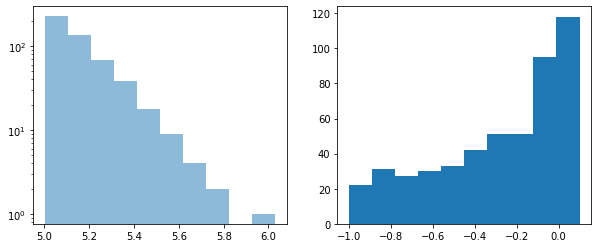

In [169]:
# Check outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(np.log10(atmo_energies), alpha=0.5)
ax[0].set_yscale("log")
ax[1].hist(np.cos(np.pi - np.arccos(atmo_directions.T[2])));

#### Full simulation

In [170]:
from python.source.cosmology import luminosity_distance
from python.source.simple_source import icrs_to_uv, Direction

In [171]:
# Preparing some useful inputs
redshift = [source_list.sources[i].redshift for i in range(source_list.N-1)]
lum_dist = [luminosity_distance(_).value for _ in redshift]
varpi_in = np.asarray([icrs_to_uv(source_list.sources[i].dec.value,
                                   source_list.sources[i].ra.value) for i in 
                       range(source_list.N-2)])

In [172]:
# Inputs 
sim_inputs = {}
sim_inputs['Ns'] = source_list.N-2

sim_inputs['z'] = redshift
sim_inputs['D'] = lum_dist[:-1]
sim_inputs['varpi'] = varpi_in

sim_inputs['Ngrid'] = len(exposure_integral.par_grids["index"])
sim_inputs['alpha_grid'] = exposure_integral.par_grids["index"]
sim_inputs['integral_grid'] = [_.value for _ in exposure_integral.integral_grid]
sim_inputs["atmo_integ_val"] = exposure_integral.integral_fixed_vals[0].value

sim_inputs["N_atmo"] = len(atmo_energies)
sim_inputs["atmo_energies"] = atmo_energies
sim_inputs["atmo_directions"] = atmo_directions
sim_inputs["atmo_weights"] = np.tile(1.0/len(atmo_energies), len(atmo_energies))
sim_inputs['alpha'] = index.value
sim_inputs['Edet_min'] = 1e5 # GeV
sim_inputs["Esrc_min"] = 1e5 # GeV
sim_inputs["Esrc_max"] = 1e8 # GeV

# Set maximum based on Esrc_max to speed up rejection sampling
# Could improve this with HMC sampling?
lbe = exposure_integral.effective_area._tE_bin_edges[:-1]
Esrc_max = sim_inputs["Esrc_max"]
aeff_max = np.max(exposure_integral.effective_area._eff_area[lbe < Esrc_max][:])
sim_inputs['aeff_max'] = aeff_max

In [173]:
# Only sample from Northern hemisphere
sim_inputs["v_lim"] = (np.cos(np.pi - np.arccos(atmo_inputs["cosz_max"])) + 1) / 2

sim_inputs["F_diff"] = diffuse_bg.flux_model.total_flux_int.value # m^-2 yr^-1
sim_inputs["F_atmo"] = atmo_bg.flux_model.total_flux_int.value 
sim_inputs['L'] = source_list.sources[0].luminosity.to(u.GeV/u.s).value

In [174]:
# Simulate
simulation = sim.sampling(data=sim_inputs, iter=1, chains=1, 
                         algorithm="Fixed_param")

#### Plot output

In [175]:
# Energies
Esrc = simulation.extract(['Esrc'])['Esrc'][0]
E = simulation.extract(['E'])['E'][0]
Edet_sim = simulation.extract(['Edet'])['Edet'][0]

# Arrival directions
event = simulation.extract(['event'])['event'][0]
event = Direction(event)
e_ra = event.d.icrs.ra.rad
e_dec = event.d.icrs.dec.rad

true_dir = simulation.extract(['omega'])['omega'][0]
true_dir = Direction(true_dir)
e_t_ra = true_dir.d.icrs.ra.rad
e_t_dec = true_dir.d.icrs.dec.rad

source = Direction(varpi_in)
s_ra = source.d.icrs.ra.rad
s_dec = source.d.icrs.dec.rad

# event type
#event_type = simulation.extract(['event_type'])['event_type'][0]
#zenith = simulation.extract(['zenith'])['zenith'][0]

In [176]:
lam = simulation.extract(['Lambda'])['Lambda'][0] - 1
Nc = sim_inputs['Ns']
label_cmap = plt.cm.get_cmap('plasma', Nc+2)

lam = list(lam)
Nsrc = sum([lam.count(_) for _ in range(int(Nc))])
Nbg = lam.count(Nc) + lam.count(Nc+1)
print('Nsrc: ', Nsrc)
print('Nbg: ', Nbg)
print('w_bg: ', Nbg / (Nbg+Nsrc))

Nsrc:  10
Nbg:  6
w_bg:  0.375


In [177]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap

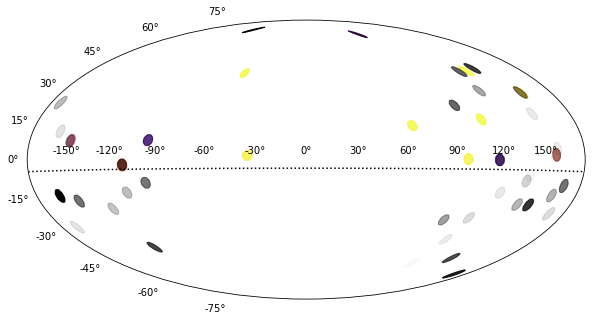

In [178]:
fig = plt.figure()
fig.set_size_inches((10, 8))
ax = fig.add_subplot(111, projection='hammer')

circles = []
for r, d, l in zip(e_ra, e_dec, lam):
    color = label_cmap.colors[int(l)]
    circles.append(mpatches.Circle((r-np.pi,d), 0.05, color=color, alpha=0.7))
collection = PatchCollection(circles, match_original=True)    
ax.add_collection(collection)   

circles = []
norm = max([1 - _/zth for _ in redshift])
for r, d, z in zip(s_ra, s_dec, redshift):
    circles.append(mpatches.Circle((r-np.pi,d), 0.05, color='k', alpha=(1-z/zth)/norm))
collection = PatchCollection(circles, match_original=True)
ax.add_collection(collection)
ax.axhline(np.deg2rad(-5), color='k', linestyle=":")

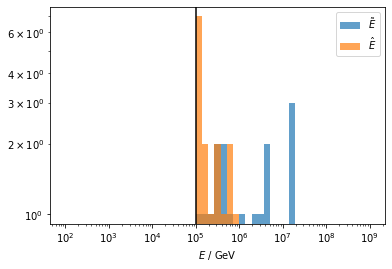

In [179]:
# Plot energies
Edet_min = sim_inputs['Edet_min']
bins = np.logspace(np.log(Edet_min/1000), np.log(1E+4*Edet_min), base = np.e)

fig, ax = plt.subplots()
ax.hist(E, bins=bins, label='$\\tilde{E}$', alpha=0.7);
ax.hist(Edet_sim, bins=bins, label='$\hat{E}$', alpha=0.7);
ax.axvline(sim_inputs["Edet_min"], color='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / GeV')
ax.legend();

## Generate Stan code for fit

In [ ]:
from python.backend.stan_generator import ParametersContext, TransformedParametersContext, ModelContext
from python.backend.variable_definitions import ParameterDef, ParameterVectorDef

In [ ]:
with StanFileGenerator("stan_files/model_code") as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("energy_spectrum.stan")
        _ = Include("sim_functions.stan")
        ntd = NorthernTracksDetectorModel()
        
    with DataContext() as dc:
        
        # Neutrinos
        N = ForwardVariableDef("N", "int")
        N_str = ["[", N, "]"]
        omega_det = ForwardArrayDef("omega_det", "unit_vector[3]", N_str)
        Edet = ForwardVariableDef("Edet", "vector[N]")
        Emin = ForwardVariableDef("Emin", "real")
        
         # Sources
        Ns = ForwardVariableDef("Ns", "int")
        Ns_str = ["[", Ns, "]"]
        Ns_1p_str = ["[", Ns, "+1]"]
        
        varpi = ForwardArrayDef("varpi", "unit_vector[3]", Ns_str)
        D = ForwardVariableDef("D", "vector[Ns]")
        z = ForwardVariableDef("z", "vector[Ns+1]")

        # Precomputed quantities
        Ngrid = ForwardVariableDef("Ngrid", "int")
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardArrayDef("integral_grid", 
                                        "vector[Ngrid]", Ns_1p_str)
        Eg = ForwardVariableDef("E_grid", "vector[Ngrid]")
        Pg = ForwardArrayDef("Pdet_grid", "vector[Ngrid]", Ns_1p_str)
        
        # Inputs
        T = ForwardVariableDef("T", "real")
        
        # Debugging
        Q_scale = ForwardVariableDef("Q_scale", "real")
        F0_scale = ForwardVariableDef("F0_scale", "real")
        
        
    with TransformedDataContext() as tdc:
        
        zenith = ForwardVariableDef("zenith", "vector[N]")
        
        with ForLoopContext(1, N, "i") as i:
            zenith[i] << StringExpression(["pi() - acos(", omega_det[i][3], ")"])
        
        StringExpression(["print(", Ngrid, ")"])
            
    with ParametersContext() as pc:
        
        Q = ParameterDef("Q", "real", 0.0, 1e60)
        F0 = ParameterDef("F0", "real", 0.0, 500)
        
        alpha = ParameterDef("alpha", "real", 1.5, 3.5)
        
        Esrc = ParameterVectorDef("Esrc", "vector", N_str, Emin, 1e8)
        
    with TransformedParametersContext() as tpc:
        
        Fs = ParameterDef("Fs", "real", 0.0)
        
        F = ForwardVariableDef("F", "vector[Ns]")
        allF = ForwardVariableDef("allF", "vector[Ns+1]")
        eps = ForwardVariableDef("eps", "vector[Ns+1]")
        
        f = ParameterDef("f", "real", 0, 1)
        FT = ParameterDef("FT", "real", 0)
        
        lp = ForwardArrayDef("lp", "vector[Ns+1]", N_str)
        logF = ForwardVariableDef("logF", "vector[Ns+1]")
        Nex = ForwardVariableDef("Nex", "real")
        E = ForwardVariableDef("E", "vector[N]")       
        
        Fs << 0
        with ForLoopContext(1, Ns, "k") as k:
            F[k] << StringExpression([Q, "/ (4 * pi() * pow(", 
                                      D[k], " * ", 3.086e22, ", 2))"])
            allF[k] << F[k]
            StringExpression([Fs," += ", F[k]])
        StringExpression("allF[Ns+1]") << F0
        FT << F0 + Fs
        f << StringExpression([Fs, " / ", FT]) 
        
        logF << StringExpression(["log(", allF, ")"])
        
        with ForLoopContext(1, N, "i") as i:
            lp[i] << logF 
            with ForLoopContext(1, "Ns+1", "k") as k:
                StringExpression([lp[i][k], " += pareto_lpdf(", Esrc[i], 
                                  " | ", Emin, " , ", alpha-1, ")"])
                E[i] << StringExpression([Esrc[i], " / (",  1+z[k], ")"]) 
                
                StringExpression(["if (", k ," < Ns+1) {\n", 
                                  lp[i][k], " += ", 
                                  ntd.angular_resolution(E[i], 
                                                         varpi[k], omega_det[i]),
                                  ";\n}\n", "else if (", k, " == Ns+1) {\n", 
                                  lp[i][k], " += ", np.log(1/(4*np.pi)), 
                                  ";\n}"])
                
                StringExpression([lp[i][k], " += ", 
                                  ntd.energy_resolution(E[i], Edet[i])])
                StringExpression([lp[i][k], " += log(interpolate(", 
                                  Eg, ", ", Pg[k], ", ", E[i], "))"])
                       
        eps << StringExpression(["get_exposure_factor(", T, ", ", Emin, ", ", 
                                 alpha, ", ", alpha_grid, ", ", 
                                 integral_grid, ", ", Ns, ")"])  
        Nex << StringExpression(["get_Nex(", allF, ", ", eps, ")"])
    
    with ModelContext() as mc:
        
        with ForLoopContext(1, N, "i") as i:
            StringExpression(["target += log_sum_exp(", lp[i], ")"])
        StringExpression(["target += -", Nex])
        
        StringExpression([Q, " ~ normal(0, ", Q_scale, ")"])
        StringExpression([F0, " ~ normal(0, ", F0_scale, ")"])
        StringExpression([alpha, " ~ normal(2.0, 2.0)"])
        
    model = cg.generate_single_file()

In [ ]:
# Compile
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, 
                              "../dev/statistical_model/4_tracks_and_cascades/stan/")]

sm = stan_utility.compile_model(filename=cg.filename, include_paths=include_paths, 
                                model_name="model")

In [ ]:
inputs = {}
inputs["N"] = len(Edet_sim)
inputs["omega_det"] = event.unit_vector
inputs["Edet"] = Edet_sim
inputs["Ns"] = source_list.N - 1

inputs['z'] = redshift
inputs['D'] = lum_dist[:-1]
inputs['varpi'] = varpi_in

inputs["Emin"] = 1e5 # GeV

inputs['Ngrid'] = len(exposure_integral.alpha_grid)
inputs['alpha_grid'] = exposure_integral.alpha_grid
inputs['integral_grid'] = exposure_integral.integral_grid
inputs["E_grid"] = E_grid
inputs["Pdet_grid"] = Pdet_grid
inputs["Q_scale"] = sim_inputs["Q"]
inputs["F0_scale"] = sim_inputs["F0"]
inputs["T"] = 1

In [ ]:
# fit
fit = sm.sampling(data=inputs, iter=500, chains=4)

In [ ]:
# View chains
fig = fit.plot([r'Q', r'F0', r'f', r'alpha', r'F', r"Nex"]);
fig.set_size_inches(20, 16)
fig.tight_layout()

In [ ]:
# View corner plot
chain = fit.extract(permuted = True)
key_list = ['F0', 'Q', 'FT', 'f', 'alpha']
labels = [r'$F_0$', r'Q', r'FT', r'f', 'alpha']
truths = [sim_inputs['F0'], sim_inputs['Q'], total_flux, 0.5, sim_inputs['alpha']]

corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
              labels = labels, truths = truths);